In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [2]:
data = california_housing.fetch_california_housing()

In [3]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])

In [4]:
df['Target'] = data['target']

In [5]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Bootstrap

<p>Практический компьютерный метод исследования распределения статистик вероятностных распределений, основанный на многократной генерации выборок методом случайного выбора с повторонеим семплов из имеющейся выборки. Позволяет просто и быстро оценивать самые разные статистики (доверительные интервалы, дисперсию, корреляцию и так далее) для сложных моделей</p>
<img src="./img/bootstrap-sample.png">
<p>Оценка статистик с помощью бутстрепа является достаточно точной</p>

In [6]:
means = []
for i in range(1000):
    idx = np.random.choice(np.arange(df.shape[0]), df.shape[0], replace=True)
    means.append(df.iloc[idx]['Target'].mean())

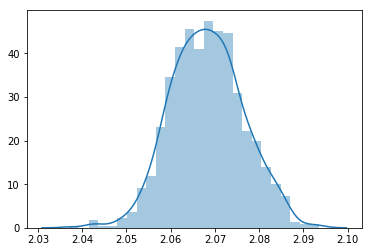

In [7]:
sns.distplot(means);

In [8]:
np.mean(means), df['Target'].mean()

(2.0682336987427323, 2.068558169089147)

<p>В машинном обучении, метод бустрепа позволяет генерировать различные выборки, на основе которых мы можем учить алгоритмы и объеденять их предсказания, самым простым методом объеденения является среднее</p>
<img src="./img/bootstrap-learn.png">

In [9]:
train_X, valid_X, train_y, valid_y = train_test_split(df.drop('Target', axis=1), df['Target'], train_size=0.7)

In [10]:
pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', KNeighborsRegressor(n_neighbors=3))])
pipeline.fit(train_X, train_y)
predicts = pipeline.predict(valid_X)
mean_squared_error(valid_y, predicts)

0.4472004909393795

In [11]:
predicts = np.zeros((50, valid_X.shape[0]))
for i in range(50):
    pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', KNeighborsRegressor(n_neighbors=3))])
    idx = np.random.choice(np.arange(train_X.shape[0]), train_X.shape[0], replace=True)
    pipeline.fit(train_X.iloc[idx], train_y.iloc[idx])
    predicts[i] = pipeline.predict(valid_X)

In [12]:
mean_squared_error(valid_y, predicts.mean(0))

0.39146086505764727

# Бэгинг 

<p>Как видно из примера аггрегация предсказаний регрессоров на разных подвыборках, дает прирост в 7%</p>
<p>Без бутстрепа у нас не получилось бы аггрегировать предсказания, поскольку тренировка на однаковых данных давала бы одинаковый результат</p>
<p>Если мы предположим что каждый из классификаторов дает предсказание с вероятностью 80%, то объеденение 5 классификаторов будет давать корректную оценку в:</p>
<p><center>$$\large{0.8^5 + C^4_50.8^40.2 + C^3_50.8^30.2^2 = 0.942}$$</center></p>
<p><center>$$\large{\mu = \sum_{i>\frac{N}{2}}^{N}C^i_Np^i(1-p)^{N-i}}$$</center></p>
<p>Данный подход назывется <b>бэггинг</b></p>
<p>Бэггинг позволяет снизить дисперсию (variance) обучаемого классификатора, уменьшая величину, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.</p>

In [13]:
from sklearn.ensemble import BaggingRegressor

In [14]:
pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', KNeighborsRegressor(n_neighbors=3))])
ensemble = BaggingRegressor(base_estimator=pipeline, n_estimators=50, n_jobs=-1)

In [15]:
ensemble.fit(train_X, train_y)

BaggingRegressor(base_estimator=Pipeline(memory=None,
                                         steps=[('scaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('estimator',
                                                 KNeighborsRegressor(algorithm='auto',
                                                                     leaf_size=30,
                                                                     metric='minkowski',
                                                                     metric_params=None,
                                                                     n_jobs=None,
                                                                     n_neighbors=3,
                                                                     p=2,
 

In [16]:
predicts = ensemble.predict(valid_X)
mean_squared_error(valid_y, predicts)

0.39211108021515545

# Случайный лес

<p>Деревья решений являются хорошими кандидатами в качестве базового алгоритма для бэггинга, поскольку они могут достигать нулевой ошибки на тренировочных данных и строить достаточно сложные границы</p>
<p>Так же будем использовать не только различные подвыборки семплов, но и признаков для них, это позволяет обучать алгоритмы более независимо, тогда наша модель тренироваться следующим образом</p>

- От 1 до N (число деревьев)
- - Сгенировать выборку $\large{X_n}$ с помощью бустрепа
- - Обучить дерево решений на данной выборке

<p>Предсказания же получаются:</p>

- От 1 до N (число деревьев)
- - Получить ответ на дереве решений и добавить его в список
- Вернуть среднее списка

In [17]:
pipeline = DecisionTreeRegressor()
pipeline.fit(train_X, train_y)
predicts = pipeline.predict(valid_X)
mean_squared_error(valid_y, predicts)

0.5306229911335405

In [18]:
predicts = np.zeros((50, valid_X.shape[0]))
for i in range(50):
    pipeline = DecisionTreeRegressor()
    idx = np.random.choice(train_X.index, train_X.shape[0], replace=True)
    feature_idx = np.random.choice(train_X.columns, int(train_X.shape[1]*0.8), replace=False)
    pipeline.fit(train_X.loc[idx, feature_idx], train_y.loc[idx])
    predicts[i] = pipeline.predict(valid_X[feature_idx])

In [19]:
mean_squared_error(valid_y, predicts.mean(0))

0.23262182449827948

In [22]:
ensemble = RandomForestRegressor(n_estimators=50, max_features=0.8)

In [23]:
ensemble.fit(train_X, train_y)
predicts = ensemble.predict(valid_X)
mean_squared_error(valid_y, predicts)

0.2526444677168718